# Predicting Network Throughput using Recurrent Neural Networks
#### @date: 26 November 2024
#### @author: Everett Tucker
#### @affiliation: North Carolina State University

This project is part of a larger project that focuses on optimizing the positions of UAV aerial base stations to maximize their communication throughput with ground users in an urban setting. This project seeks to predict ground user's future throughput based on their past data. This will improve the value function of the reinforcement learning model and make it more accurate to a realistic setting.

This uses code uses functionality from Sci-Kit Learn, Numpy, Pandas, Matplotlib, and PyTorch for data processing, conversion, and model building.

## Working with the Signal Dataset
### Importing necessary libraries

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression

### Importing data from files into Pandas Dataframes

In [2]:
signal_df = pd.read_csv("data\\cellular_network_analysis_dataset\\signal_metrics.csv")
network_df = pd.read_csv("data\\network_anomaly_dataset\\network_dataset_labeled.csv")

### Processing data

I start with the signal_df from the "Cellular Network Analysis" Dataset. I first convert the data time format into an absolute time in milliseconds from Epoch. I am also looking at some of the types and seperating network types into different dataframes.

In [3]:
# Convert timestamp to microseconds
def convertTime(s):
    return (datetime.strptime(s, "%Y-%m-%d %H:%M:%S.%f") - datetime(1970, 1, 1)) // timedelta(microseconds=1)

# For the signal_df, delta_time = 187210173 microseconds always

# Seperating Network Types, because they may have disparate data
unique_network_types = set(signal_df["Network Type"])
print(f'Unique Network Types: {unique_network_types}')  # 3G, 4G, 5G, LTE, roughly evenly split

print(f'Total Count: {len(signal_df)}')
for t in unique_network_types:
    print(f'Network Type Count {t}: {len(signal_df.loc[signal_df["Network Type"] == t])}')

fsdf = signal_df.copy().drop(["Locality", "Latitude", "Longitude"], axis=1)
fsdf.insert(0, column="Timestamp (Microsecond)", value=[convertTime(x) for x in fsdf["Timestamp"]])
fsdf = fsdf.drop("Timestamp", axis=1)

Unique Network Types: {'5G', 'LTE', '3G', '4G'}
Total Count: 16829
Network Type Count 5G: 4178
Network Type Count LTE: 4224
Network Type Count 3G: 4208
Network Type Count 4G: 4219


In [4]:
# Cleaning the 3G data to remove constant, duplicate, or superfluous information
gen_three_df = fsdf.copy().loc[fsdf["Network Type"] == "3G"]
gen_three_df = gen_three_df.reindex(np.arange(len(gen_three_df)), method="pad")
gen_three_df = gen_three_df.drop(["Signal Quality (%)","BB60C Measurement (dBm)", "srsRAN Measurement (dBm)", "BladeRFxA9 Measurement (dBm)"], axis=1)
gen_three_df = gen_three_df.drop_duplicates(ignore_index=True)

### Data Analysis and Visualization

Analyzing the data by graphic the trends over time, and using log plots to understand changes in the data, and using a linear model to understand the correlation between several features in the input.

Notes:
The variation of the Throughput, which we want to predict, is fairly low compared to the other variables, this is good.
Each of the variables appears fairly random, and there is not a clear correlation over time for any of them
We will probably need a more complex model, and perhaps some periodic functions to predict them.
Something like a Fourier Transform seems plasible at this point.

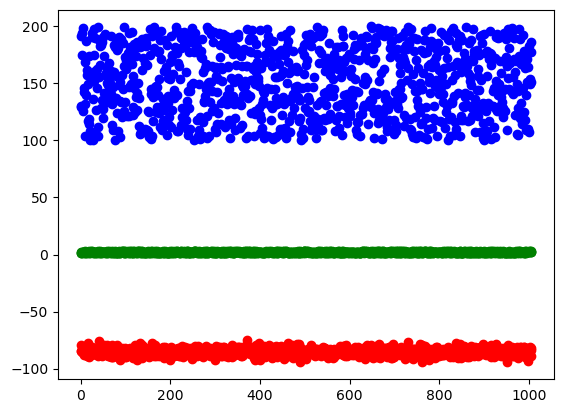

In [5]:
# Visualizing some of the individual data trends
plt.scatter(x=np.arange(len(gen_three_df)), y=gen_three_df["Signal Strength (dBm)"], color="red")
plt.scatter(x=np.arange(len(gen_three_df)), y=gen_three_df["Data Throughput (Mbps)"], color="green")
plt.scatter(x=np.arange(len(gen_three_df)), y=gen_three_df["Latency (ms)"], color="blue")
plt.show()

Using a linear model to analyze the correlation between the differnet types of data.

* Notes:
This score is very bad, and suggests there is basically no correlation between the data
Perhaps the correlation when adding the timestamp will be better

In [7]:
# Running a linear model to find the correlation between these three variables
X = []
X.append(gen_three_df["Signal Strength (dBm)"])
X.append(gen_three_df["Latency (ms)"])
X = np.array(X).T
y = np.array([gen_three_df["Data Throughput (Mbps)"]]).T
res = LinearRegression().fit(X, y)
print(f'Linear Correlation Coefficient: {res.score(X, y)}')

Linear Correlation Coefficient: 0.006373494428007831


Running another linear model with the timestamp as a feature to include any linear correlations with respect to time. 

* Notes: This score is only incrementally better than the last linear regression fit. It suggests that the data doesn't correlate over time either, so a more complex model is needed.

In [8]:
# Running another linear model with the timestamp to see if the data is more correlated over time
X = []
for col in ["Signal Strength (dBm)", "Latency (ms)", "Timestamp (Microsecond)"]:
    X.append(gen_three_df[col])
X = np.array(X).T
y = np.array([gen_three_df["Data Throughput (Mbps)"]]).T
res = LinearRegression().fit(X, y)
print(f'Linear Correlation Coefficient: {res.score(X, y)}')

Linear Correlation Coefficient: 0.006377205238150552


Plotting a lag plot to analyze the changes of the data over time.

* Notes: 
We can change the values of lag in the above function to plot different lag values, but we will find that they all look random. This means that there is no discernable linear relationship or trendline in the data.

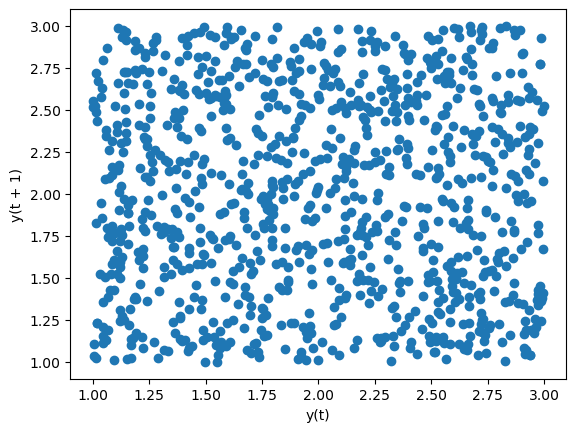

In [9]:
pd.plotting.lag_plot(gen_three_df["Data Throughput (Mbps)"], lag=1)
plt.show()

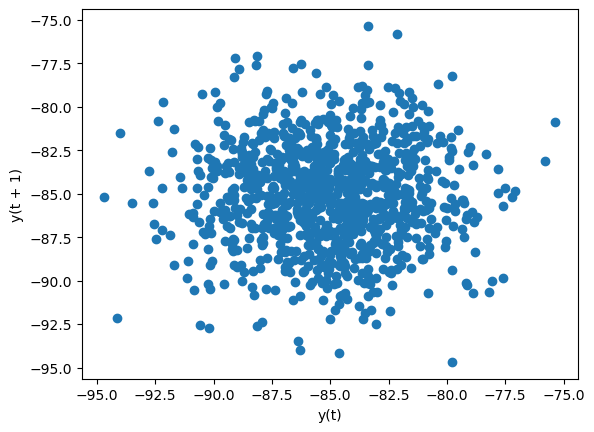

In [10]:
pd.plotting.lag_plot(gen_three_df["Signal Strength (dBm)"], lag=1)
plt.show()

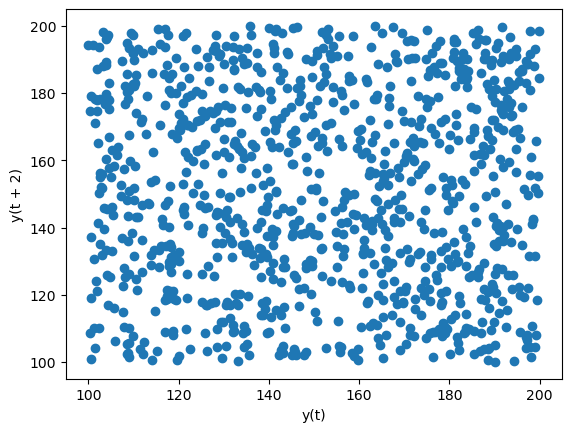

In [11]:
pd.plotting.lag_plot(gen_three_df["Latency (ms)"], lag=2)
plt.show()

### Implementing an autoregressive Multi-layer Perceptron Regressor

Because of the high variance and the randomness in the data, the patterns are likely too much to be understand by a simple model, so we try a neural network forst.

In [13]:
# Because of the high variance in the data, and the complex patterns, I want to try a autoregressive neural network to train the data on

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor

print(f'Dataset Size: {len(gen_three_df)}')

# Make sure that we don't shuffle for the time series
train_data, test_data = train_test_split(gen_three_df["Data Throughput (Mbps)"], test_size=0.2, random_state=42, shuffle=False)
test_data = test_data.reset_index(drop=True)

# Setting the buffer to use for the neural network, in number of samples
buffer = 3

# Constructing the training data from the buffer
train_X = []
train_y = []
for i in range(buffer, len(train_data) - 1):
    train_X.append(train_data[i - buffer:i + 1])
    train_y.append(train_data[i + 1])

train_X = np.array(train_X)
train_y = np.array(train_y)

# Training the model
model = MLPRegressor(hidden_layer_sizes=[4 * buffer], activation="relu", solver="adam", max_iter=10000000)
model.fit(train_X, train_y)

# Creating the test data from the buffer
test_X = []
test_y = []
for i in range(buffer, len(test_data) - 1):
    test_X.append(test_data[i - buffer:i+1])
    test_y.append(test_data[i+1])

test_X = np.array(test_X)
test_y = np.array(test_y)

print(f'Loss: {model.loss_}')
print(f'Model Score: {model.score(test_X, test_y)}')

Dataset Size: 1006
Loss: 0.17143148636146477
Model Score: -0.01624210269461268


* Using GridSearchCV to optimize the hyperparameters in the MLP model. We try multiple different hidden layer architectures, activation functions, solvers, and learning rate values before finding the best one.

In [14]:
# Finding the best parameters using the grid search CV method and some different parameters
model = MLPRegressor(max_iter=1000000)
param_list = {"hidden_layer_sizes": [(buffer,), (buffer,buffer,)], "activation": ["identity", "logistic", "tanh", "relu"], "solver": ["lbfgs", "sgd", "adam"], "alpha": [0.00005, 0.0005]}
grid = GridSearchCV(estimator=model, param_grid=param_list)
grid.fit(train_X, train_y)
opt_params = grid.best_params_
print(f'Best Parameters {opt_params}')

Best Parameters {'activation': 'logistic', 'alpha': 5e-05, 'hidden_layer_sizes': (3, 3), 'solver': 'sgd'}


Rerunning the model with the best parameters that we determined in the last cell. 

* *Notes:*
According to these results, this data is likely too random to reliably predict with a model.
This neural network provides the best results, and it is unlikely that any other results are more reliable.

* *Future work for the signal dataset:*
In the future, I want to look through more of the data in these data sets, and potentially draw some more meaningful conclusions from that data. There is a lot of data in my dataset that I didn't explore, that could potentially yield some more meaningful results.

In [15]:
# Rerunning the results with the optimal parameters gained from GridSearchCV
best_model = MLPRegressor(hidden_layer_sizes=(buffer, buffer,), activation="logistic", solver="sgd", alpha=0.00005)
best_model.fit(train_X, train_y)

print(f'Best Loss {best_model.loss_}')
print(f'Best Score {best_model.score(test_X, test_y)}')

Best Loss 0.17134360296548215
Best Score -0.005517459530117508


## Working with the Network Dataset
### Data Visualization and Analysis

Plotting data time series to find patterns and look at the randomness compared to the previous dataset that I examined.

* Notes: This doesn't look as random as some of the previous data that I looked at, which is a good sign. It has some noticable rises and falls, and perhaps even a semblance of periodicidy.

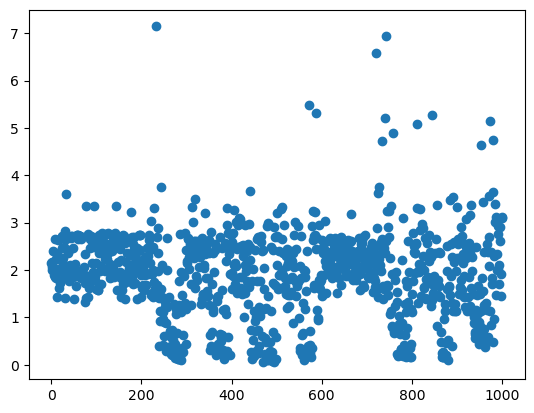

In [18]:
# Examining the dataset for randomness
plt.scatter(np.arange(len(network_df)), network_df["throughput"]);

Examining columns and the first 5 entries of each column to find which columns are numerical and could be used for regression in the future.

* Notes: From this examination it looks like throughput, congestion, packet_loss, latency, and jitter are useful metrics for predicting future data.
We'll select this columns and graph them together and seperately to examine the initial relationships.

In [19]:
df = network_df.drop("Video target", axis=1)
print(df.columns)
for col in df.columns:
    print(f'{col}: {np.unique(df[col])[:10]}')

Index(['timestamp', 'bandwidth', 'throughput', 'congestion', 'packet_loss',
       'latency', 'jitter', 'Routers', 'Planned route', 'Network measure',
       'Network target', 'Percentage video occupancy', 'Bitrate video',
       'Number videos', 'anomaly_throughput', 'anomaly_congestion',
       'anomaly_packet_loss', 'anomaly_latency', 'anomaly_jitter', 'anomaly'],
      dtype='object')
timestamp: ['2024-05-11 12:00:15' '2024-05-11 12:00:43' '2024-05-11 12:01:12'
 '2024-05-11 12:01:40' '2024-05-11 12:02:08' '2024-05-11 12:02:36'
 '2024-05-11 12:03:05' '2024-05-11 12:03:34' '2024-05-11 12:04:01'
 '2024-05-11 12:04:30']
bandwidth: [2]
throughput: [0.05 0.08 0.1  0.11 0.12 0.13 0.14 0.16 0.17 0.18]
congestion: [0.03 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13]
packet_loss: [ 0.   2.5  5.   7.5 10.  12.5 15.  17.5 20.  22.5]
latency: [4.48 4.58 4.72 4.78 4.86 4.95 4.97 4.99 5.02 5.04]
jitter: [0.   0.18 0.2  0.21 0.22 0.23 0.25 0.26 0.27 0.28]
Routers: ['up xrv1,2,3' 'up xrv6']
Planned 

### Data Augmentation

Removing the data points that are marked as anomalies in some way. These data points are likely not as good for regression or for constructing a model that is supposed to reflect usual data usage from ground users.

In [22]:
# filtering out data points marked as anomalies
for x in ["_throughput", "_congestion", "_packet_loss", "_latency", "_jitter", ""]:
    df = df.loc[df["anomaly" + x] == 0]
    
print(f'Dataset Size after Removals: {len(df)}')

Dataset Size after Removals: 747


Filtering dataset to extract features that are useful for classification

In [24]:
filtered_df = df.filter(items=["throughput", "congestion", "packet_loss", "latency", "jitter"], axis=1)
print(f'Filtered Dataset Size: {len(filtered_df)}')
print(filtered_df.head())

Filtered Dataset Size: 747
   throughput  congestion  packet_loss  latency  jitter
0        2.15        0.38          0.0     6.58    0.52
1        2.16        0.12          0.0     5.36    0.34
2        2.00        0.08          0.0     6.29    0.23
3        2.07        0.07          0.0     5.91    0.51
4        2.40        0.08          0.0     5.81    0.71


Printing network metrics over time

* Notes: From this we can see that there is a pretty evident correlation between the data points. It would be nice to run a simple linear regression model first to determine this correlation, using throughput as the dependent variable. There really aren't that many data points though to test on, so the model might overfit or not be fully representative of less common values.

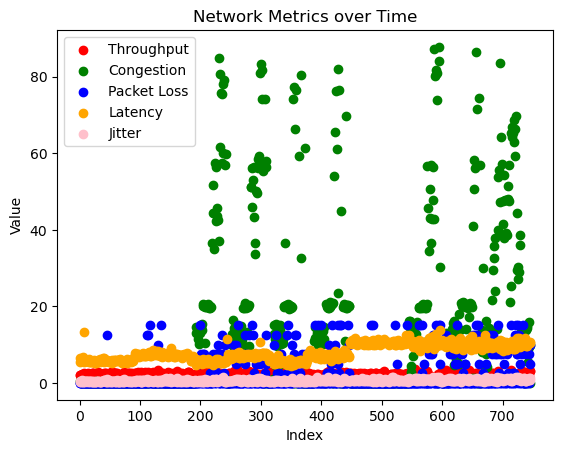

In [25]:
plt.scatter(np.arange(len(filtered_df)), filtered_df["throughput"], color="red", label="Throughput")
plt.scatter(np.arange(len(filtered_df)), filtered_df["congestion"], color="green", label="Congestion")
plt.scatter(np.arange(len(filtered_df)), filtered_df["packet_loss"], color="blue", label="Packet Loss")
plt.scatter(np.arange(len(filtered_df)), filtered_df["latency"], color="orange", label="Latency")
plt.scatter(np.arange(len(filtered_df)), filtered_df["jitter"], color="pink", label="Jitter")
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Network Metrics over Time")
plt.legend()
plt.show()

Using a Linear Regression Model to determine the correlation between features that I am going to classify on.

* Notes: From these results we can see that there is no strong correlation between the data points at each time step
This is note exactly decisive, because it could mean that the data is both difficult to predict but also independent,
meaning that we have access to more information. Also, the score of the linear model increased after removing the anomalies from the dataset. This is probably good news for the quality of the data and the identification of the outliers.

In [26]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

# Creating testing and training sets
X = np.array(filtered_df.filter(items=["congestion", "packet_loss", "latency", "jitter"], axis=1))
y = np.array(filtered_df["throughput"])

# Training basic model
model.fit(X, y)
print(f'Model Score: {model.score(X, y)}')

Model Score: 0.2600908797519631


Running some lag plots for different time series in the total data set.

- The lag plot of network throughput is fairly random with a slight 
- The lag plot of congestion is pretty linear
- The lag plot of packet_loss is discrete and random
- The lag plot of latency is very linear and clumpy
- the lag plot of jitter is fairly random with a slight linear correlation 

            

Text(0, 0.5, 'Throughput at Time t + 1')

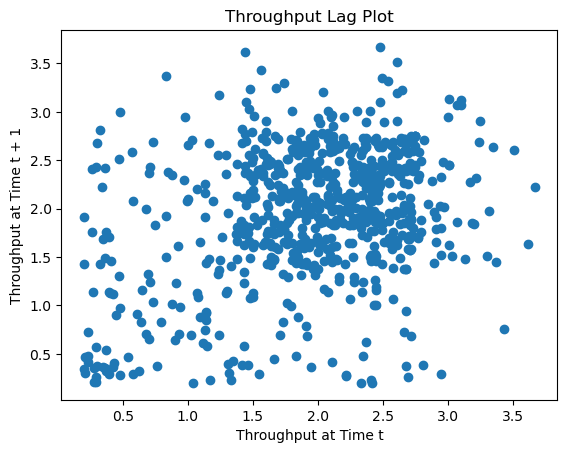

In [27]:
pd.plotting.lag_plot(filtered_df["throughput"], lag=1)
plt.title("Throughput Lag Plot")
plt.xlabel("Throughput at Time t")
plt.ylabel("Throughput at Time t + 1")
# pd.plotting.lag_plot(filtered_df["congestion"], lag=1)
# pd.plotting.lag_plot(filtered_df["packet_loss"], lag=1)
# pd.plotting.lag_plot(filtered_df["latency"], lag=1)
# pd.plotting.lag_plot(filtered_df["jitter"], lag=1)

### Model Training

Using a train / test split for prepare the data for model training.

In [28]:
from sklearn.model_selection import train_test_split


# Redefining X and y from previous definition
X = np.array(filtered_df.filter(items=["throughput", "congestion", "packet_loss", "latency", "jitter"], axis=1))
y = np.array(filtered_df["throughput"])

# Make sure not to shuffle for time series
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f'Train input shape: {trainX.shape}')
print(f'Train output shape: {trainY.shape}')

Train input shape: (597, 5)
Train output shape: (597,)


Importing modules necessary for the PyTorch Recurrent Neural Network

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.set_default_dtype(torch.float64)

Writing the PyTorch Recurrent Neural Network Architecture
- This is the original model used in the all the future computations

In [31]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, k):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.k = k

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = []
        for i in range(k):
            self.h2h.append(nn.Linear(hidden_size, hidden_size))
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, input_data, hidden_data, idx):
        """
        Feeds the algorithm forward using the input data and the vector of previous data
        """
        hidden_data = F.relu(self.i2h(input_data) + self.h2h[idx](hidden_data))
        if idx == self.k - 1:
            return self.h2o(hidden_data)
        else:
            return hidden_data

    def init_hidden(self):
        """
        Returns the initial value of the previous hidden data
        """
        return torch.zeros(1, self.hidden_size, dtype=torch.float64)

Testing the new RNN class for the corrent tensor sizes and any errors

In [33]:
# Making a RNN Object with the desired sizes
rnn = RNN(5, 5, 1, 10)
# This method takes the previous hidden layer, the input data from the specific time step, and outputs 
output = rnn(torch.zeros(1, 5), torch.zeros(1, 5), 0)
print(f'Output Tensor: {output}')

Output Tensor: tensor([[0.0000, 0.5708, 0.0000, 0.0000, 0.8306]], grad_fn=<ReluBackward0>)


In [34]:
# Running a complete cycle with some sample from the front of the test array
k = 6
rnn = RNN(5, 5, 1, k)
tensorX = torch.tensor(X, dtype=torch.float64).detach().clone()
tensorY = torch.tensor(y, dtype=torch.float64).detach().clone()

trainX, testX, trainY, testY = train_test_split(tensorX, tensorY, test_size=0.2, shuffle=False)

# Should return a single number output
output = rnn.init_hidden()
for i in range(k):
    output = rnn(trainX[i], output, i)

print(f'Predicted Throughput: {output.squeeze().item()}')

Predicted Throughput: 0.447233876948703


Defining a train method for the RNN and laying out some of the hyperparameters

In [35]:
# Series should be of shape (k, 5) throughput is a float, k is an int

# Hyperparameters

def train(series, throughput, k, criterion, learning_rate, rnn):
    # Initialize hidden data
    hidden = rnn.init_hidden()

    # Initialize gradient
    rnn.zero_grad()

    # Feed forward through the model
    for i in range(k):
        hidden = rnn(series[i], hidden, i)

    # Calculate loss and backpropogate
    loss = criterion(hidden.reshape(1), torch.tensor(throughput, dtype=torch.float64).reshape(1))
    loss.backward()

    # Update the parameters from the gradient descent
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return hidden, loss.item()

Training an iteration through the entire dataset, and plotting the loss curve

* Notes: The loss function looks really stable, which is nice. It still fluctuates a little bit so it might be better to lower the learning rate some.

C:\Users\legoe\AppData\Local\Temp\ipykernel_24136\1998810907.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(hidden.reshape(1), torch.tensor(throughput, dtype=torch.float64).reshape(1))


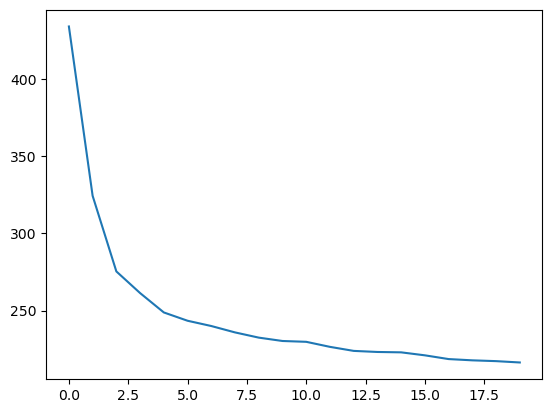

In [38]:
# Training through the entire training data set

n = len(trainX)
iterations = 20
losses = []
rnn = RNN(5, 5, 1, k)
for j in range(iterations):
    total_loss = 0
    for i in range(n - k):
        output, loss = train(trainX[i:i+k], trainY[i+k], k, nn.MSELoss(), 0.001, rnn)
        total_loss += loss
    losses.append(total_loss)

plt.figure()
plt.plot(np.arange(iterations), losses);

Writing a random data loader to sample random data values from the training set, instead of just training through the entire set every time from start to finish.

In [39]:
import random
"""
Making a random data loader to make the training of the model more efficient
"""

def load_data(trainX, trainY, k, n):
    i = random.choice(range(n - k))
    return trainX[i:i+k], trainY[i+k]

Repeating the training process with the random data loader

C:\Users\legoe\AppData\Local\Temp\ipykernel_24136\1998810907.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(hidden.reshape(1), torch.tensor(throughput, dtype=torch.float64).reshape(1))


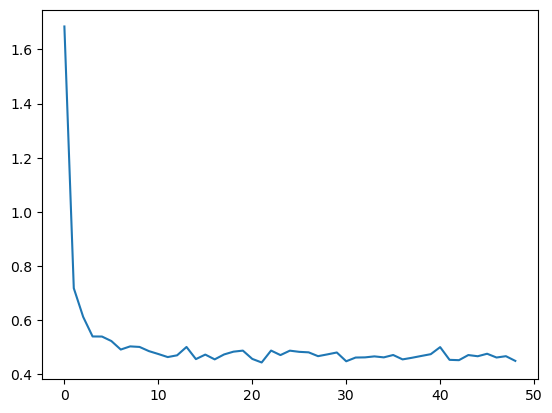

In [42]:
epochs = 1
iterations = 50000
learning_rate = 0.0001
criterion = nn.L1Loss()
k = 3

# Setting up data
network_df = pd.read_csv("data\\network_anomaly_dataset\\network_dataset_labeled.csv")
X = np.array(filtered_df.filter(items=["throughput", "congestion", "packet_loss", "latency", "jitter"], axis=1))
y = np.array(filtered_df["throughput"])

tensorX = torch.tensor(X, dtype=torch.float64).detach().clone()
tensorY = torch.tensor(y, dtype=torch.float64).detach().clone()

trainX, testX, trainY, testY = train_test_split(tensorX, tensorY, test_size=0.2, shuffle=False)

n = len(trainX)
for _ in range(epochs):
    losses = []
    net = RNN(5, 5, 1, k)
    total_loss = 0
    for j in range(iterations):
        tX, tY = load_data(trainX, trainY, k, n)
        output, loss = train(tX, tY, k, criterion, learning_rate, net)
        total_loss += loss
        if j % 1000 == 0:
            losses.append(total_loss / 1000)
            total_loss = 0
        
    plt.plot(losses[1:])
    plt.show()

# Shows the average loss up to that point

Thinking about other things to try to improve the model:

* Principal component analysis on the number of features in the input, I could potentially take it down from about 5 to 2
and save some computation time, but it would also allow me to increase the iterations about x3 with the same computation
time.
* Use a validation set to test for overfitting in the model and test its accuracy before the final test data set
* Try some different loss functions, the SmoothL1Loss or the L1Loss could be good bets
* Data normalization - this might be a big one along with the principal component analysis
* SmoothL1Loss gives a lower score (0.16), but that doesn't necessarily mean anything, the curve looks good though
* L1Loss decent error? (0.47), but I don't really know anything about that

After training:
* Test the model by plot residuals over time for the testing set.
* Are they close to the final outputted data? Is it close enough for my applications or does it fail badly?

*Implementing some of the new ideas*
* Defining an error function to compare the final results and test the model
* Also defining a final moving average convolution to smooth my final results and make them potentially more accurate.

In [43]:
"""
Trying to use a moving average to get a more accurate prediction of the data that is also more stable
It is somewhat important to my application that the prediction values for this are stable so the UAVs don't make any
crazy movements
"""

def moving_average(arr, l):
    rtn = np.convolve(arr, np.ones(l)/l, mode="same")
    for i in range(int(l / 2)):
        rtn[i] = np.mean(arr)
        rtn[len(rtn) - i - 1] = np.mean(arr)
    return rtn

def RMSE(expected, actual, n):
    total = 0
    for i in range(n):
        total += (expected[i] - actual[i]) ** 2
    return np.sqrt(total / n).item()

*Implementing Normalization and Principal Component Analysis*

This step may help to reduce the variability in the size of the scalars that are used in training, and make the model converge to a more optimal policy sooner.

In [44]:
from sklearn.decomposition import PCA

"""
Time to try some PCA, perhaps with all the components of the original array
I also might try just normalizing each of the arrays prior to training on them, that could slightly improve results.
"""

# Regenerating data arrays
network_df = pd.read_csv("data\\network_anomaly_dataset\\network_dataset_labeled.csv")

# Running a normalization on the data first, then PCA
X = np.array([(filtered_df[x] - np.mean(filtered_df[x])) / np.std(filtered_df[x]) for x in ["throughput", "congestion", "packet_loss", "latency", "jitter"]])
X = X.T

pca_components = 3
pca = PCA(n_components=pca_components, svd_solver="full")
stdX = pca.fit_transform(X)
stdY = stdX[:,0]

tensorX_pca = torch.tensor(stdX, dtype=torch.float64).detach().clone()
tensorY_pca = torch.tensor(stdY, dtype=torch.float64).detach().clone()

# Splitting into test, train, and validation sets
trainX_pca, testX_pca, trainY_pca, testY_pca = train_test_split(tensorX_pca, tensorY_pca, test_size=0.2, shuffle=False)
trainX_pca, validX_pca, trainY_pca, validY_pca = train_test_split(trainX_pca, trainY_pca, test_size=0.2, shuffle=False)

*Running a new model with the normalization and PCA*

In [1]:
# Ok, the data from the PCA looks pretty good, time to run it through the model
# Don't forget to modify the testing and validation sets as well...

# Hyperparameters
criterion = nn.MSELoss()
learning_rate = 0.0001
iterations = 300000  # TODO: Change to 300,000
k = 3

losses = []
net = RNN(pca_components, pca_components, 1, k)
total_loss = 0
n = len(trainX_pca)
for j in range(iterations):
    tX, tY = load_data(trainX_pca, trainY_pca, k, n)
    output, loss = train(tX, tY, k, criterion, learning_rate, net)
    total_loss += loss
    if j % 1000 == 0:
        losses.append(total_loss / 1000)
        total_loss = 0
        print(f'{j / iterations * 100} percent complete.')
        
plt.plot(losses[1:])
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.title("MSE Loss vs. Iteration for RNN Model Training")
plt.show()

NameError: name 'nn' is not defined

*Defining the Mean Absolute Percent Error metric for comparing data*

* This metric is more useful across data of different scalar sizes.

In [53]:
"""
Percent error is a better metric to compare across the instance of the PCA and the non-PCA results.
The PCA results look more correlated on the graph, and I just want to show that quantitatively.
"""

def MAPE(expected, actual):
    n = min(len(expected), len(actual))
    total = 0
    for i in range(n):
        total += 2 * np.abs((expected[i] - actual[i].item()) / (actual[i].item() + expected[i]))
    return (total / n).item()

*Introducing a prediction function to score the final data*

In [57]:
# Using the validation set to test accuracy of the model by plotting the regression plot

def predict(series, throughput, k, rnn):
    # Initialize hidden data
    hidden = net.init_hidden()

    # Feed forward through the model
    for i in range(k):
        hidden = net(series[i], hidden, i)

    return hidden

*Comparing the actual and expected results for the training data*

* These results include the convolution and the end, and follow very closely to the training data.
* The fact that they follow so closely could indicate some amount of overfitting in the data

Training RMSE: 0.8782544442384508
Training MAPE: 4.375128104367077


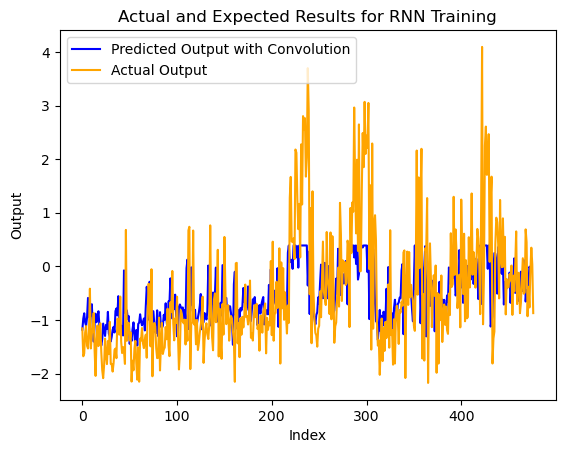

In [58]:
# Classifying training accuracy

actual = []  # Stores expected - actual results for all validation trials
n = len(trainX_pca)
for i in range(n - k):
    actual.append(predict(trainX_pca[i:i+k], trainY_pca[i+k], k, net).item())

plt.plot(actual, color="blue", label="Predicted Output with Convolution")
plt.title("Actual and Expected Results for RNN Training")
plt.xlabel("Index")
plt.ylabel("Output")
plt.plot(trainY_pca, color="orange", label="Actual Output")
plt.legend()

print(f'Training RMSE: {RMSE(moving_average(actual, 10), trainY_pca, len(actual))}')
print(f'Training MAPE: {MAPE(moving_average(actual, 6), trainY_pca)}')

*Comparing the actual and expected results for the validation data*

* It looks like the trendlines are somewhat close, though there is a little bit of drop near the end of the time series.
* This could be the result of some overfitting of the model in the training phase

In [2]:
# Classifying validation accuracy

actual = []  # Stores expected - actual results for all validation trials
n = len(validX_pca)
for i in range(n - k):
    actual.append(predict(validX_pca[i:i+k], validY_pca[i+k], k, net).item())

plt.plot(actual, color="blue")
plt.plot(validY_pca, color="orange")

print(f'Validation RMSE: {RMSE(moving_average(actual, 6), validY_pca, len(actual))}')
print(f'Validation MAPE: {MAPE(moving_average(actual, 6), validY_pca)}')

NameError: name 'validX_pca' is not defined

*Testing the final model*

* We introduce a baseline moving average, which would be a naive way to approach this problem, to score our model.
* We plot the final test results with the baseline, actual, and prediction
* Scores for RMSE and MAPE are listed below to score the model more quantitatively

Test RMSE from predicted: 1.5046053159754806
Test MAPE from predicted: 2.050897049976633
Test MAPE from baseline prediction: 2.4888763024002456
Percent Improvement Over Baseline: 21.355496729033895


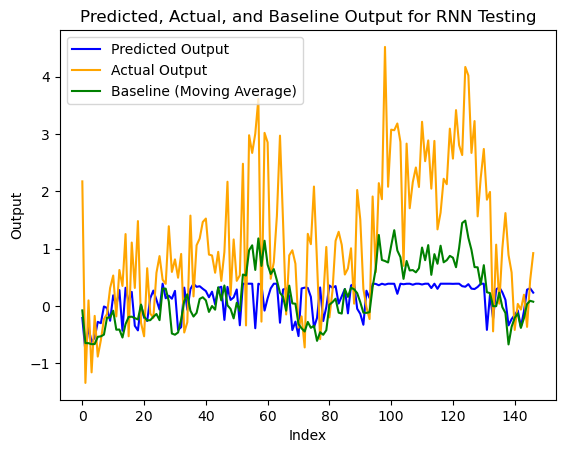

In [64]:
# Classifying final test accuracy

actual = []  # Stores expected - actual results for all validation trials
baseline = []
n = len(testX_pca)
for i in range(n - k):
    actual.append(predict(testX_pca[i:i+k], testY_pca[i+k], k, net).item())
    baseline.append(torch.mean(testX_pca[i:i+k]))

plt.plot(actual, color="blue", label="Predicted Output")
plt.xlabel("Index")
plt.ylabel("Output")
plt.title("Predicted, Actual, and Baseline Output for RNN Testing")
plt.plot(testY_pca[:n-k], color="orange", label="Actual Output")
plt.plot(baseline, color="green", label="Baseline (Moving Average)")
plt.legend()
print(f'Test RMSE from predicted: {RMSE(moving_average(actual, 6), testY_pca, len(actual))}')
print(f'Test MAPE from predicted: {MAPE(moving_average(actual, 6), testY_pca)}')
print(f'Test MAPE from baseline prediction: {MAPE(moving_average(actual, 6), baseline)}')
print(f'Percent Improvement Over Baseline: {(MAPE(moving_average(actual, 6), baseline) / MAPE(moving_average(actual, 6), testY_pca) - 1) * 100}')